<a href="https://colab.research.google.com/github/zzzzzhou/twitter_text_mining/blob/main/twitter140_LSTM_tensorflow_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zhedizhou","key":"58dd59a4cabd2016c399cea883b7a3ec"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d kazanova/sentiment140

 88% 71.0M/80.9M [00:00<00:00, 104MB/s]
100% 80.9M/80.9M [00:00<00:00, 105MB/s]


In [3]:
!mkdir -p ~/.twitter
!cp sentiment140.zip ~/.twitter/

In [4]:
!unzip sentiment140.zip -d twitter

Archive:  sentiment140.zip
  inflating: twitter/training.1600000.processed.noemoticon.csv  


In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import re

print("Tensorflow Version",tf.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Tensorflow Version 2.8.0


In [6]:
df = pd.read_csv(r'twitter/training.1600000.processed.noemoticon.csv',
                 encoding = 'latin', header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
df.groupby('sentiment').count()

,id,date,query,user_id,text
sentiment,,,,,
0,800000,800000,800000,800000,800000
4,800000,800000,800000,800000,800000


In [9]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [10]:
df.loc[df.sentiment==0,'sentiment'] = 'Negative'

In [11]:
df.loc[df.sentiment==4,'sentiment'] = 'Positive'

Text(0.5, 1.0, 'Sentiment Data Distribution')

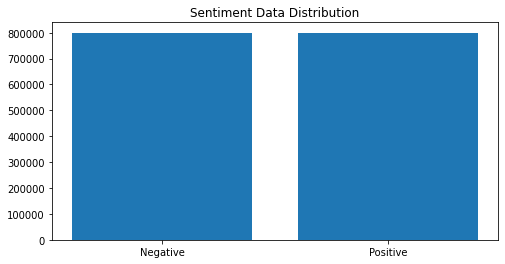

In [12]:
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [13]:
import random
random_idx_list = [random.randint(1,len(df.text)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it

,sentiment,text
1491956,Positive,@michaelbathurst Its easier to follow people w...
767300,Negative,realizing I forgot to bring my sandwhich for l...
211812,Negative,"the note says, &quot;Just an experiment,&quot;..."
541119,Negative,Fuckkk make it go away already!
752432,Negative,http://twitpic.com/855ma - WE no longer look l...
389824,Negative,Work soon :/ and I have the WORST mosquito bit...
91691,Negative,@agholmes I just haven't heard from any of you...
1183978,Positive,Hmm. Haven't edited it though. I'll prolly do ...
632377,Negative,@cece_newnew Didn't invite me
231406,Negative,is being annoyed by Noah.


In [14]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"   #expression used to remove @ and links

In [15]:
def preprocess(text, stem=True):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)    #remove stopwords and re-assemble as a sentence

In [16]:
df.text = df.text.apply(lambda x: preprocess(x))

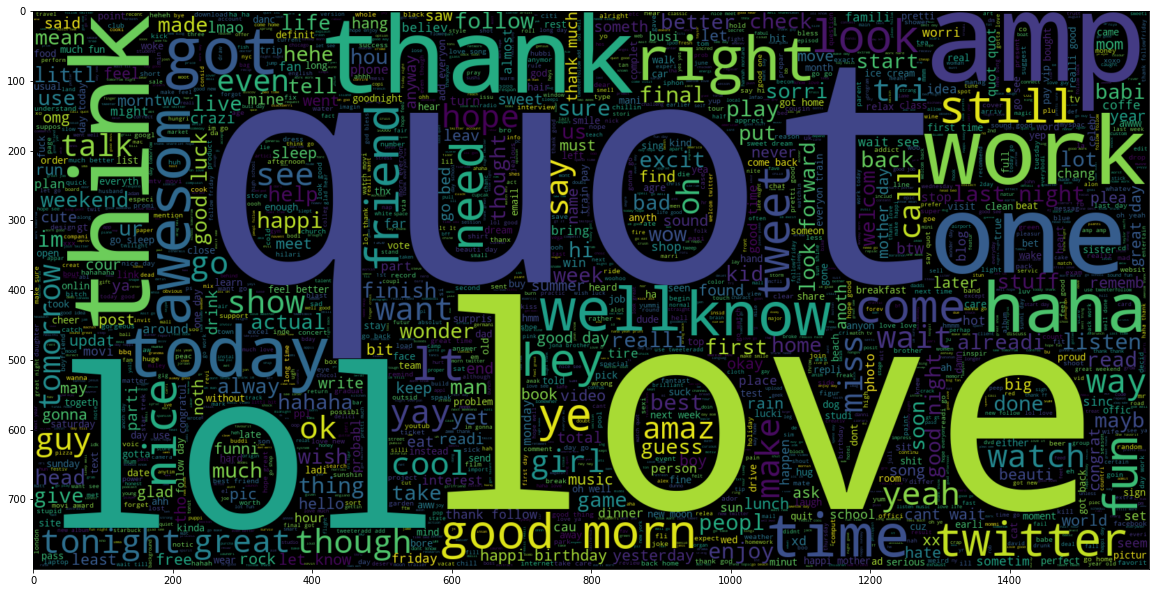

In [17]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

In [18]:
TRAIN_SIZE = 0.8
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


In [19]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index         #get a dictionary about word index
vocab_size = len(tokenizer.word_index) + 1 #vocab size is used to define embedding layer
print("Vocabulary Size :", vocab_size) 

Vocabulary Size : 248857


In [20]:
train_data.head()

,sentiment,text
553155,Negative,wait phone call hubbi get time even plane woul...
1562121,Positive,yessss make happi haha
1378932,Positive,reali bor noth saturday hahah 2 week till big ...
1071874,Positive,hey ti ti hope
1244499,Positive,laughin non stop today


In [21]:
from keras.preprocessing.sequence import pad_sequences
MAX_SEQUENCE_LENGTH = 30   #because lstm require same lenth input sequence
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


In [22]:
x_train[0:10]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,    46,   133,   113,   768,
            2,    10,    71,   868,    58,   751, 22353, 13636,   738,
          120,  2039,  1340],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,  3809,
           31,    57,    50],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,  3163,  9302,   182,   319,   884,
           33,    53,   262,   176,     3,    17,    17,  1025,    89,
           53,     7, 12195],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,    84,
         4760,  4760,    27],
       [    0,     0,     0,

In [23]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


In [24]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-04-14 22:38:50--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-04-14 22:38:50--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-04-14 22:38:50--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [25]:
GLOVE_EMB = '/content/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10

In [26]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs    #get embedding weight index from glove
f.close()

print('Found %s word vectors.' %len(embeddings_index))  

Found 400000 word vectors.


In [27]:
for i, (k, v) in enumerate(embeddings_index.items()):
    if i in range(0, 10):
        print(k, v)

the [ 4.6560e-02  2.1318e-01 -7.4364e-03 -4.5854e-01 -3.5639e-02  2.3643e-01
 -2.8836e-01  2.1521e-01 -1.3486e-01 -1.6413e+00 -2.6091e-01  3.2434e-02
  5.6621e-02 -4.3296e-02 -2.1672e-02  2.2476e-01 -7.5129e-02 -6.7018e-02
 -1.4247e-01  3.8825e-02 -1.8951e-01  2.9977e-01  3.9305e-01  1.7887e-01
 -1.7343e-01 -2.1178e-01  2.3617e-01 -6.3681e-02 -4.2318e-01 -1.1661e-01
  9.3754e-02  1.7296e-01 -3.3073e-01  4.9112e-01 -6.8995e-01 -9.2462e-02
  2.4742e-01 -1.7991e-01  9.7908e-02  8.3118e-02  1.5299e-01 -2.7276e-01
 -3.8934e-02  5.4453e-01  5.3737e-01  2.9105e-01 -7.3514e-03  4.7880e-02
 -4.0760e-01 -2.6759e-02  1.7919e-01  1.0977e-02 -1.0963e-01 -2.6395e-01
  7.3990e-02  2.6236e-01 -1.5080e-01  3.4623e-01  2.5758e-01  1.1971e-01
 -3.7135e-02 -7.1593e-02  4.3898e-01 -4.0764e-02  1.6425e-02 -4.4640e-01
  1.7197e-01  4.6246e-02  5.8639e-02  4.1499e-02  5.3948e-01  5.2495e-01
  1.1361e-01 -4.8315e-02 -3.6385e-01  1.8704e-01  9.2761e-02 -1.1129e-01
 -4.2085e-01  1.3992e-01 -3.9338e-01 -6.7945e-0

In [28]:
vc1 = embeddings_index['the']
vc1.shape

(300,)

In [29]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector #for each word in corpus will have a embedding accordingly

In [30]:
embedding_layer = tf.keras.layers.Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False)

In [31]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [32]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [33]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [34]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Training on GPU...


In [ ]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=50,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/50
1250/1250 [==============================] - 145s 116ms/step - loss: 0.4804 - accuracy: 0.7652 - val_loss: 0.4883 - val_accuracy: 0.7623 - lr: 0.0010
Epoch 2/50
1250/1250 [==============================] - 138s 110ms/step - loss: 0.4790 - accuracy: 0.7664 - val_loss: 0.4875 - val_accuracy: 0.7614 - lr: 0.0010
Epoch 3/50
1250/1250 [==============================] - 138s 110ms/step - loss: 0.4779 - accuracy: 0.7664 - val_loss: 0.4860 - val_accuracy: 0.7632 - lr: 0.0010
Epoch 4/50
1250/1250 [==============================] - 136s 109ms/step - loss: 0.4769 - accuracy: 0.7674 - val_loss: 0.4864 - val_accuracy: 0.7629 - lr: 0.0010
Epoch 5/50
1250/1250 [==============================] - 136s 108ms/step - loss: 0.4761 - accuracy: 0.7681 - val_loss: 0.4893 - val_accuracy: 0.7624 - lr: 0.0010
Epoch 6/50
1250/1250 [==============================] - 135s 108ms/step - loss: 0.4756 - accuracy: 0.7683 - val_loss: 0.4870 - val_accuracy: 0.7626 - lr: 0.0010
Epoch 7/50
1250/1250 [============

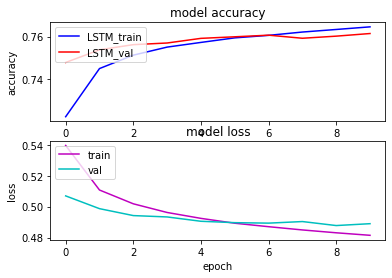

In [36]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [37]:
test_loss, test_accuracy = model.evaluate(x_test,y_test)

10000/10000 [==============================] - 181s 18ms/step - loss: 0.4890 - accuracy: 0.7614
